In [83]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

In [84]:
sim_name = "zaidel"

In [85]:

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 100  # Number of columns
delr = 5.0  # Column width
delc = 1.0  # Row width
top = np.zeros(ncol, dtype=float) + 25.0  # Top of the model
strt = 23.0  # Starting head
k11 = 0.0001  # Horizontal hydraulic conductivity

In [86]:
H1 = 23.0  # Constant head in column 1
H2 = 2.0 # Constant head in column <ncol>

# stress period data for CHD
chd_spd = [
        [0, 0, 0, H1],
        [0, 0, ncol - 1, H2],
    ]

In [87]:
# Cell conversion type
icelltype = 0

In [88]:
# Initial bottom at zero
botm = np.zeros((nlay, nrow, ncol), dtype=float)

In [89]:
# add drain on top
drain_data = []
for j in range(ncol):
    elev = top[j]
    cond_drain = 100.0
    drain_data.append([(0, 0, j), elev, cond_drain])

In [90]:
# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

In [91]:
# Solver parameters
nouter = 100
ninner = 50
hclose = 1e-6
rclose = 1e-6

In [92]:
# setup simulation
sim_ws = sim_name
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="all",
    linear_acceleration="cg",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose}",
    csv_inner_output_filerecord="ims.csv",
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="")
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=k11,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)

drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drain_data)

head_filerecord = f"{sim_name}.hds"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=head_filerecord,
    saverecord=[("HEAD", "ALL")],
)



In [93]:
def save_run_plot(sim):
    # save
    shutil.rmtree(sim.sim_path)
    sim.write_simulation(silent=True)

    # run
    result, _ = sim.run_simulation(silent=True)
    if not result:
        print("run failed...")
        return
    else:
        print("run succeeded...")
    
    # plot head
    gwf_model = sim.get_model()
    plt.figure(figsize=(10,3))
    pxs = flopy.plot.PlotCrossSection(model=gwf_model, line={"row": 0})

    head = gwf_model.output.head().get_data()
    pa = pxs.plot_array(head, head=head)
    pxs.plot_grid()
    pxs.plot_bc("CHD")
    plt.colorbar(pa)

    # plot ims
    plt.figure(figsize=(10,3))
    ims_csv = os.path.join(sim.sim_path, "ims.csv")
    df = pd.read_csv(ims_csv)    
    plt.plot(df["total_inner_iterations"], abs(df["solution_inner_dvmax"]))
    plt.plot(df["total_inner_iterations"], abs(df["solution_inner_rmax"]), "lightblue")

    # mark next outer
    nouter_diff = [int(df["nouter"][i + 1] - df["nouter"][i]) for i in range(df["nouter"].size - 1)]
    new_outers = np.where(np.asarray(nouter_diff) == 1)[0] + 1
    for idx_outer in new_outers:
        plt.vlines(idx_outer + 0.5, 0.0, 25.0, color='grey', linestyle='dashed')
    plt.hlines(hclose, plt.xlim()[0], plt.xlim()[1], color='grey')

    plt.gca().set_yscale('log')



run succeeded...


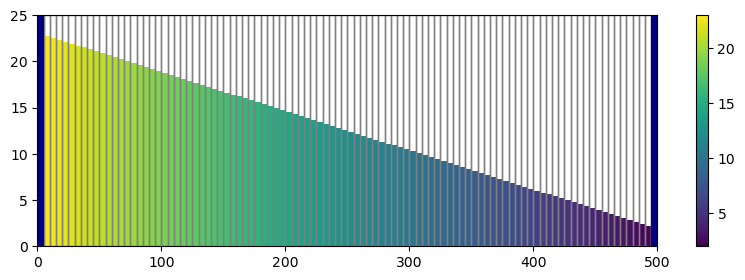

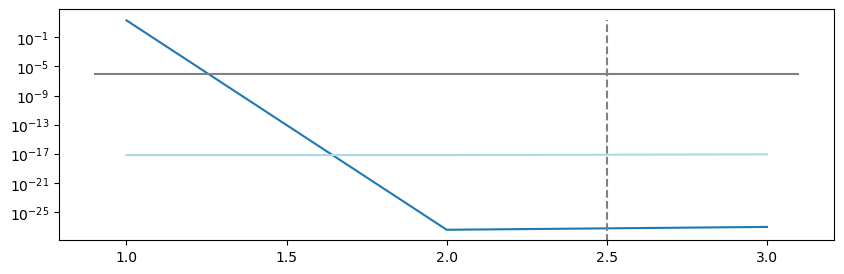

In [94]:
save_run_plot(sim)

In [95]:
# add staircase bottom
dis = sim.get_model().get_package("DIS")
nsteps = 5
for j in range(ncol):
    dis.botm[:, :, j] = 20.0 - 5.0 * (nsteps*j//ncol)

run succeeded...


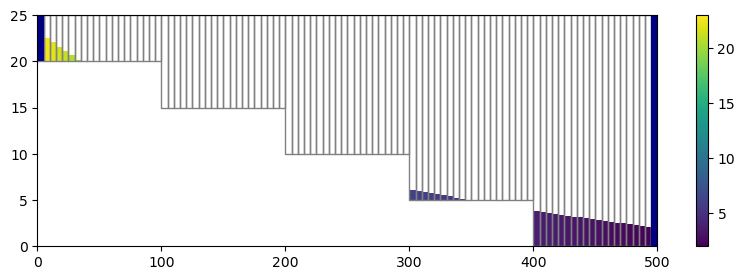

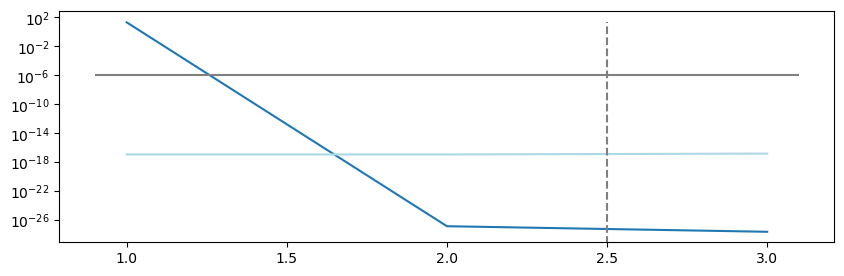

In [96]:
save_run_plot(sim)

In [97]:
# run unconfined
sim.get_model().npf.icelltype = 1

run succeeded...


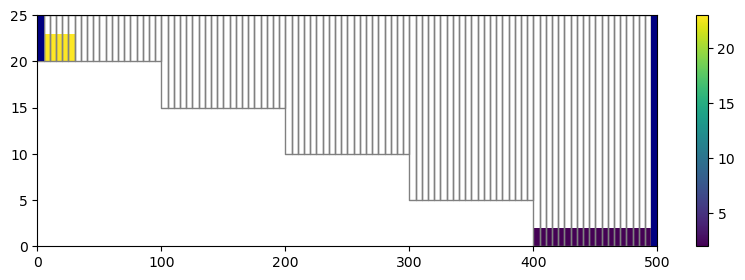

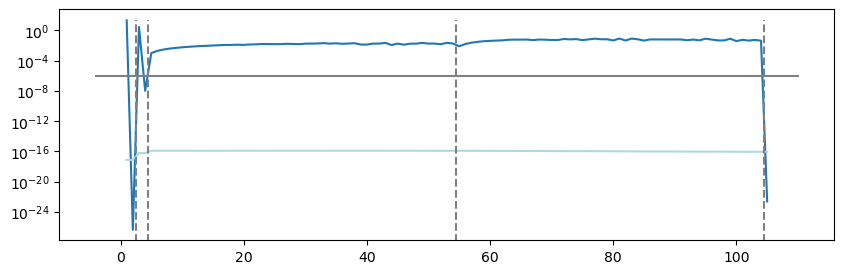

In [98]:
save_run_plot(sim)

In [99]:
# activate newton formulation
sim.get_model().newtonoptions = "newton"

In [100]:
save_run_plot(sim)

run failed...


In [101]:
# set complexity to complex (and unset CG)
sim.ims.linear_acceleration = None
sim.ims.complexity = "complex"

run succeeded...


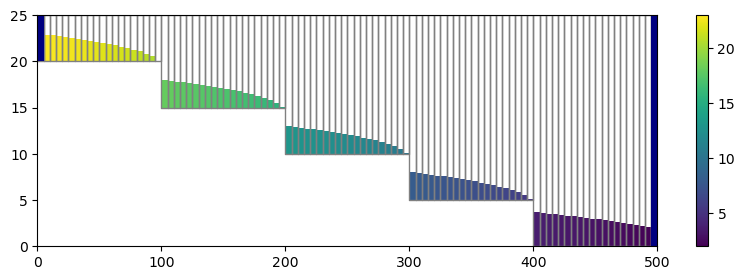

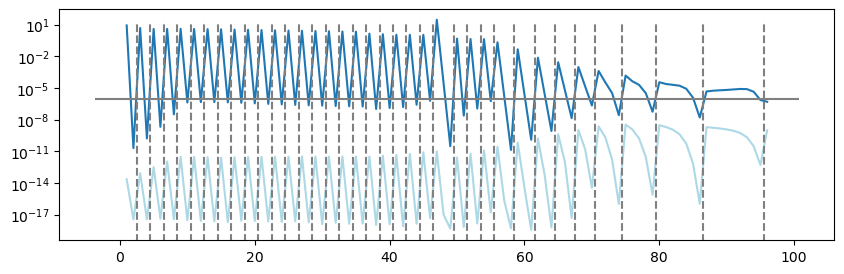

In [102]:
save_run_plot(sim)

In [103]:
# set complexity to complex (and unset CG)
sim.ims.linear_acceleration = "bicgstab"
sim.ims.complexity = None

run succeeded...


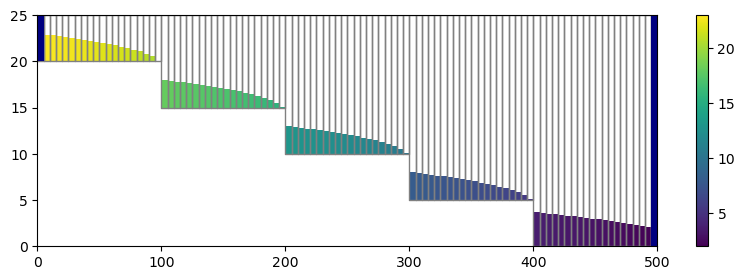

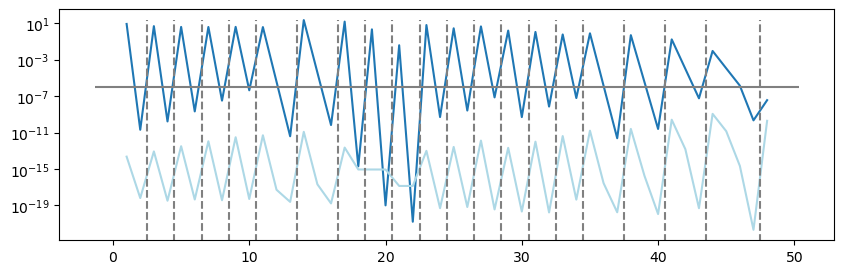

In [104]:
save_run_plot(sim)